#### Импорты

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#### Спектр

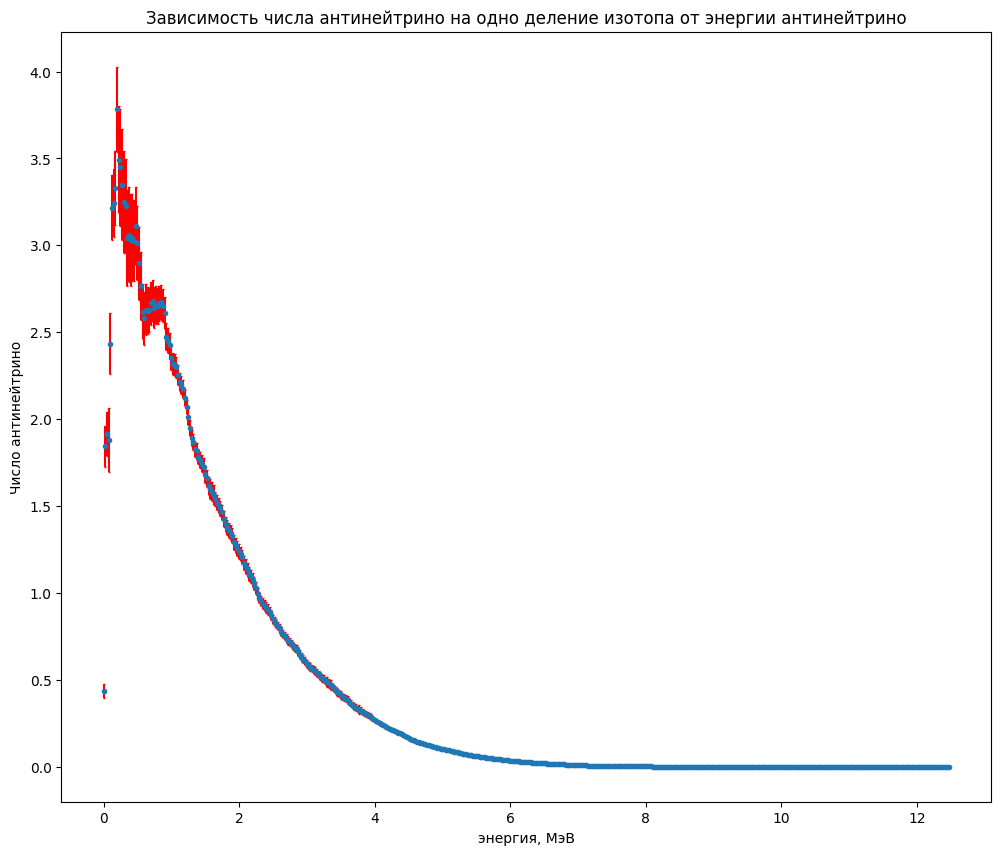

In [2]:
file = uproot.open("BESTIOLE_amp_Fallot_Spectra.root")
key = "235-Best;1"
x = file[key].axis().edges()[:-1]
y = file[key].values()
err = file[key].errors()
plt.figure(figsize=(12, 10))
plt.errorbar(x, y, err, ecolor="r", fmt='.', capsize=1)
plt.title("Зависимость числа антинейтрино на одно деление изотопа от энергии антинейтрино")
plt.xlabel("энергия, МэВ")
plt.ylabel("Число антинейтрино")
plt.show()

#### Функции

In [3]:
def binary_search(list, key): # бинарный поиск
    low = 0
    high = len(list) - 1

    while low <= high:
        mid = (low + high) // 2
        midVal = list[mid]
        if midVal == key:
            return mid
        if midVal > key:
            high = mid - 1
        else:
            low = mid + 1
    return mid


def linear_interpolation(energy, x,  y):
    ind = binary_search(x, energy)
    if energy > x[ind]:
        ind += 1
    k = (y[ind] - y[ind - 1]) / (x[ind] - x[ind - 1])
    b = y[ind] - k * x[ind]
    return k * energy + b

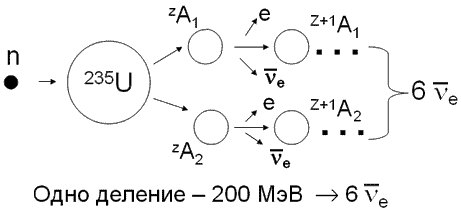  

<a href="http://nuclphys.sinp.msu.ru/neutrino_astr/na3.htm" target="_blank">здесь</a> написано, что cреднее число β-распадов, испытываемых осколками, равно 6.

#### Классы

In [4]:
class Tablet():

    def __init__(self, coord, activity):
        self.t_coord = coord[:] # координаты таблетки
        self.activity = activity # активность изотопа

    
    def get_flux_in_point(self, coord, energy, x, y):  # x, y - данные из спектра
        area = 4 * np.pi * sum([(coord[i] - self.t_coord[i]) ** 2 for i in range(len(coord))])
        s = linear_interpolation(energy, x, y)
        return s / area * self.activity


class Reactor():

    def __init__(self, params):
        self.R = params["R"] # радиус и высота реактора
        self.l = params["l"] # число слоёв в реакторе
        self.n = params["n"] # число диагоналей
        self.k = params["k"] # число таблеток на радиусе 
        eps = 1e-10 # эпсилон
        dr = R / n # расстояние между таблетками на радиусах
        dphi = np.pi / n # шаг угла
        dz = R / (l - 1) # шаг высоты
        self.tablets = [Tablet((r * np.cos(phi), r * np.sin(phi), z), 6) for r in np.arange(dr, R + eps, dr) for phi in np.arange(0, 2 * np.pi, dphi) for z in np.arange(-R / 2, R / 2 + eps, dz)]

    
    def flux(self, coord, energy, x, y): # поток
        result_flux = sum([tablet.get_flux_in_point(coord, energy, x, y) for tablet in self.tablets])
        return result_flux

    
    def show(self): # красота
        x = [el.t_coord[0] for el in self.tablets]
        y = [el.t_coord[1] for el in self.tablets]
        z = [el.t_coord[2] for el in self.tablets]
        fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers')])
        fig.show()

#### Пример работы программы

In [7]:
R = 1.5
l = 3
n = 4
k = 4
params = {"R": R, "l": l, "n": n, "k": k}
reactor = Reactor(params)

coord = (7, 7, 7) # координаты заданы в метрах
energy = 0.5 # энергия задана в МэВ
flux = reactor.flux(coord, energy, x, y)
print(flux)

0.9427571160608559


In [6]:
reactor.show()